***Introduction***

To begin with we need to imports modules from Cirq and Mitiq libraries to facilitate the simulation of quantum circuits and apply error mitigation strategies such as Zero-Noise Extrapolation (ZNE), Probabilistic Error Cancellation (PEC), and Dynamical Decoupling (DDD).

Additionally, it imports specific functions for handling noise models, converting circuits to Mitiq format, and representing operations with local depolarizing noise. These functionalities are crucial for optimizing the performance and accuracy of quantum computations in the presence of noise.

In [3]:
import cirq
import matplotlib.pyplot as plt

from cirq import DensityMatrixSimulator, depolarize, amplitude_damp # selecting simulator and noise
from mitiq.interface import convert_to_mitiq
from mitiq.pec.representations.depolarizing import represent_operations_in_circuit_with_local_depolarizing_noise

from mitiq import pec, zne, ddd
from mitiq.zne.scaling import fold_gates_at_random


```execute```

is the executor with depolarizing noise and amplitude damping noise.


- Args:

    circuit: The input quantum circuit to be executed.
    
    noise_level: The level of depolarizing noise to be applied to the circuit, defaults to 0.2.

- Returns:

    The real part of the matrix element (0,0) of the final density matrix, representing the expectation value of the |0⟩⟨0| state prepared by the circuit executed with depolarizing noise.



In [46]:
def execute(circuit, noise_level=0.2, damp=0.1):
    """Returns Tr[ρ |0⟩⟨0|] (expectation value)where ρ is the state prepared by the circuit
    executed with depolarizing noise.
    """
    mitiq_circuit, _ = convert_to_mitiq(circuit)
    noisy_circuit = mitiq_circuit.with_noise(depolarize(p=noise_level))
    noisy_circuit = noisy_circuit.with_noise(amplitude_damp(gamma=damp))

    return DensityMatrixSimulator().simulate(noisy_circuit).final_density_matrix[0, 0].real #real value of matrix element (0,0)

```launch:```

helper method in style of a closure that allows launching cascading different types of mitigations

In [47]:
def launch(parent_executor, executor, circuit, **executor_args):
   executor = parent_executor(executor=executor, **executor_args)
   return executor, executor(circuit)

In [54]:
keys = ["PEC", "ZNE", "DDD", "DDD_PEC", "ZNE_PEC", "DDD_PEC_ZNE"]

def calculate(executor, circuit, reps, factory, rule):
   values = [0] * 6
   pec_executor, values[0] = launch(pec.mitigate_executor, executor, circuit, representations= reps)
   _, values[1] = launch(zne.mitigate_executor, executor, circuit, factory=factory)
   _, values[2] = launch(ddd.mitigate_executor, executor, circuit, rule=rule)
   _, values[3] = launch(ddd.mitigate_executor,pec_executor, circuit, rule = rule)
   zne_pec_executor, values[4] = launch(zne.mitigate_executor, pec_executor, circuit, factory=factory)
   _, values[5] = launch(ddd.mitigate_executor, zne_pec_executor, circuit, rule=rule)
   return values


Simple circuit that equates to Identity operation (via two X gates)

In [55]:
a0 = cirq.q("a")
ops4 = [cirq.X(a0), cirq.X(a0)]
circuitA = cirq.Circuit(ops4)

noise_level = 0.2
factory = zne.RichardsonFactory([1.0, 2.0])

noisy_valueA= execute(circuitA, noise_level)
ideal_valueA= execute(circuitA, noise_level=0.0,damp=0.0)
rule = ddd.rules.xx
repsA = represent_operations_in_circuit_with_local_depolarizing_noise(circuitA, noise_level)

values = calculate(execute, circuitA, repsA, factory, rule)


/opt/homebrew/anaconda3/envs/qrize/lib/python3.11/site-packages/mitiq/zne/inference.py:96: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  warnings.warn(
/opt/homebrew/anaconda3/envs/qrize/lib/python3.11/site-packages/mitiq/zne/inference.py:96: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  warnings.warn(
/opt/homebrew/anaconda3/envs/qrize/lib/python3.11/site-packages/mitiq/zne/inference.py:96: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  warnings.warn(


Different Mitigation strategies and combinations compared against each other

In [56]:
print("ideal value", ideal_valueA)
print(f"without mitigation {noisy_valueA :.5f}")
for key,value in zip(keys, values):
   print(f"{key} mitigation   {value :.5f}")

ideal value 1.0
without mitigation 0.73027
PEC mitigation   0.89834
ZNE mitigation   0.84776
DDD mitigation   0.73027
DDD_PEC mitigation   0.89041
ZNE_PEC mitigation   1.00845
DDD_PEC_ZNE mitigation   0.94722


In [59]:
%matplotlib inline
# Creating the bar chart
def plot_it(keys, values):
   plt.figure(figsize=(10, 6))
   plt.bar(keys, values, color='skyblue')
   plt.xlabel('Strategy')
   plt.ylabel('Value')
   plt.title('Mitigation values')

   # Adding a horizontal line
   plt.axhline(y=noisy_valueA, color='r', linestyle='--', label=f'Noisey Value ({noisy_valueA:.2f})')
   plt.legend()  # Display a legend

   plt.show()
print(values)

[0.8983403634901552, 0.8477624058723449, 0.7302666306495667, 0.8904068809860888, 1.0084532318984372, 0.9472220950441372]


ZNE_PEC combination stack as the best combination for the combo of amplitude dampening and noise errors. This can easily vary for different scripts and needs more analysis before a claim can be made

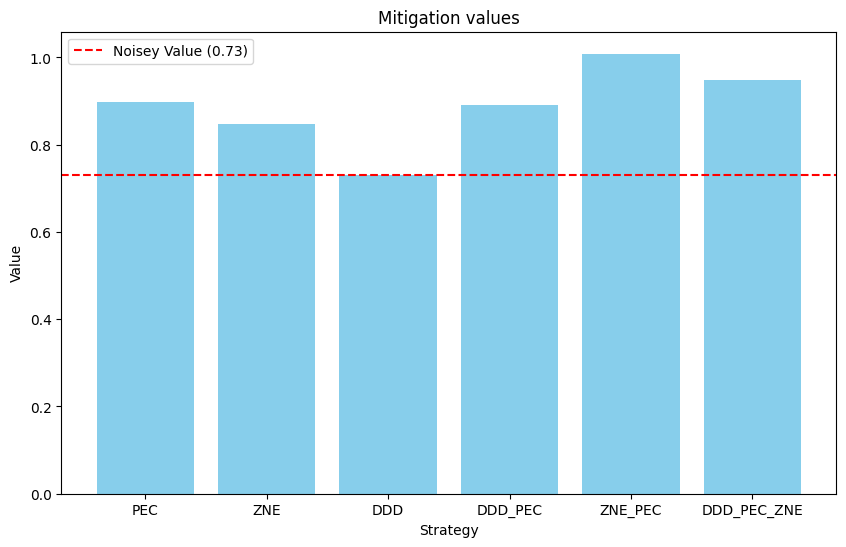

In [60]:
plot_it(keys, values)

A larger circuit that takes over 4 hrs to execute.

In [63]:
a0 = cirq.q("a")
ops1 = [cirq.H(a0), cirq.H(a0), cirq.H(a0), cirq.H(a0)]
circuitA = cirq.Circuit(ops1)

noise_level = 0.2
factory = zne.RichardsonFactory([1.0, 2.0])

noisy_valueA= execute(circuitA, noise_level)
ideal_valueA= execute(circuitA, noise_level=0.0, damp=0.0)
rule = ddd.rules.xx
repsA = represent_operations_in_circuit_with_local_depolarizing_noise(circuitA, noise_level)

values = calculate(execute, circuitA, repsA, factory, rule)

/opt/homebrew/anaconda3/envs/qrize/lib/python3.11/site-packages/mitiq/zne/inference.py:96: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  warnings.warn(
/opt/homebrew/anaconda3/envs/qrize/lib/python3.11/site-packages/mitiq/zne/inference.py:96: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  warnings.warn(
/opt/homebrew/anaconda3/envs/qrize/lib/python3.11/site-packages/mitiq/pec/pec.py:123: LargeSampleWarning: The number of PEC samples is very large. It may take several minutes. It may be necessary to reduce 'precision' or 'num_samples'.
  warnings.warn(_LARGE_SAMPLE_WARN, LargeSampleWarning)
/opt/homebrew/anaconda3/envs/qrize/lib/python3.11/site-packages/mitiq/zne/inference.py:96: UserWarning: The input circuit is very short. This may reduce the accuracy of noise scaling.
  warnings.warn(
/opt/homebrew/anaconda3/envs/qrize/lib/python3.11/site-packages/mitiq/pec/pec.py:123: LargeSampleWarning:

In [ ]:
plot_it(keys, values)